# This notebook prepares the files for the ML pipeline


In [16]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import pickle
import random


### make train, val, test datasets

In [4]:
# Open the combined data file 
with open('reconstructed_data.pkl', 'rb') as f:
    reconstructed_df = pickle.load(f)


# Load the wavelength axis
with open('wavelength_axis.pkl', 'rb') as f:
    wavelength_axis = pickle.load(f)

# show keys
reconstructed_df.columns

Index(['log_m', 'z', 'spectrum', 'type'], dtype='object')

In [7]:
from sklearn.model_selection import train_test_split

# First Split: Train (including validation) and Test
df_train_val, df_test = train_test_split(reconstructed_df, test_size=0.15, random_state=42) # 15% test

# Second Split: Train and Validation from X_temp and Y_temp
# Note: 15% of the remaining 85% is 0.1765 (approximately 17.65%)
df_train, df_val = train_test_split(df_train_val, test_size=0.1765, random_state=42) # About 15% of total

# Saving the Split DataFrames
df_train.to_pickle('train_dataset.pickle')
df_val.to_pickle('validation_dataset.pickle')
df_test.to_pickle('test_dataset.pickle')

## Make normalised spectra 

In [13]:
import scipy.ndimage
from tqdm import tqdm

def rebin_array_with_interpolation(array, num_bins):
    # Original positions (x values) - creating n+1 edges for n data points
    original_positions = np.linspace(0, len(array), len(array) + 1)

    # New positions for the rebinned array
    new_positions = np.linspace(0, len(array), num_bins + 1)

    # Interpolation function - note we use original_positions[:-1] and array
    interpolation_function = scipy.interpolate.interp1d(original_positions[:-1], array, kind='linear', bounds_error=False, fill_value="extrapolate")

    # Interpolating at new positions - excluding the last edge
    rebinned_array = interpolation_function(new_positions[:-1])

    return rebinned_array


#### training set

In [115]:
df_train = pd.read_pickle('train_dataset.pickle')

# Extract features for training set
all_spectra_train = np.stack(df_train['spectrum'].values)
all_spectra_train.shape

# Normalization of training spectra
all_spectra_train_normalized = np.zeros(all_spectra_train.shape)

# Continuum array
continuum_train = np.zeros(all_spectra_train.shape)

# definition of continuum points
num_bins = 5
continuum_points_train = np.zeros((all_spectra_train.shape[0], num_bins)) # Corrected shape

continuum_median = [] # a variable that is onoly used to store the continuum points in the loop
for i in tqdm(range(all_spectra_train.shape[0]), desc="Processing"):
    # modeling the continuum with a median filter
    continuum_median = scipy.ndimage.median_filter(all_spectra_train[i, :], size=100)
    # storing the continuum (just for cecking later on)
    continuum_train[i, :] =  continuum_median
    # subtracting the continuum
    all_spectra_train_normalized[i, :] = all_spectra_train[i, :] - continuum_median
    # normalizing the spectra according to the maximum value
    all_spectra_train_normalized[i, :] = all_spectra_train_normalized[i, :] / all_spectra_train_normalized[i, :].max()
    # rebinning the continuum points
    continuum_points_train[i, :] = rebin_array_with_interpolation(continuum_median, num_bins=num_bins)


# Saving the normalized spectra and continuum points
with open('spectra_train_normalized.pkl', 'wb') as file:
    pickle.dump(all_spectra_train_normalized, file)

# Saving the continuum points
with open('train_continuum.pkl', 'wb') as file:
    pickle.dump(continuum_points_train, file)   


Processing: 100%|██████████| 1353/1353 [00:00<00:00, 1506.31it/s]


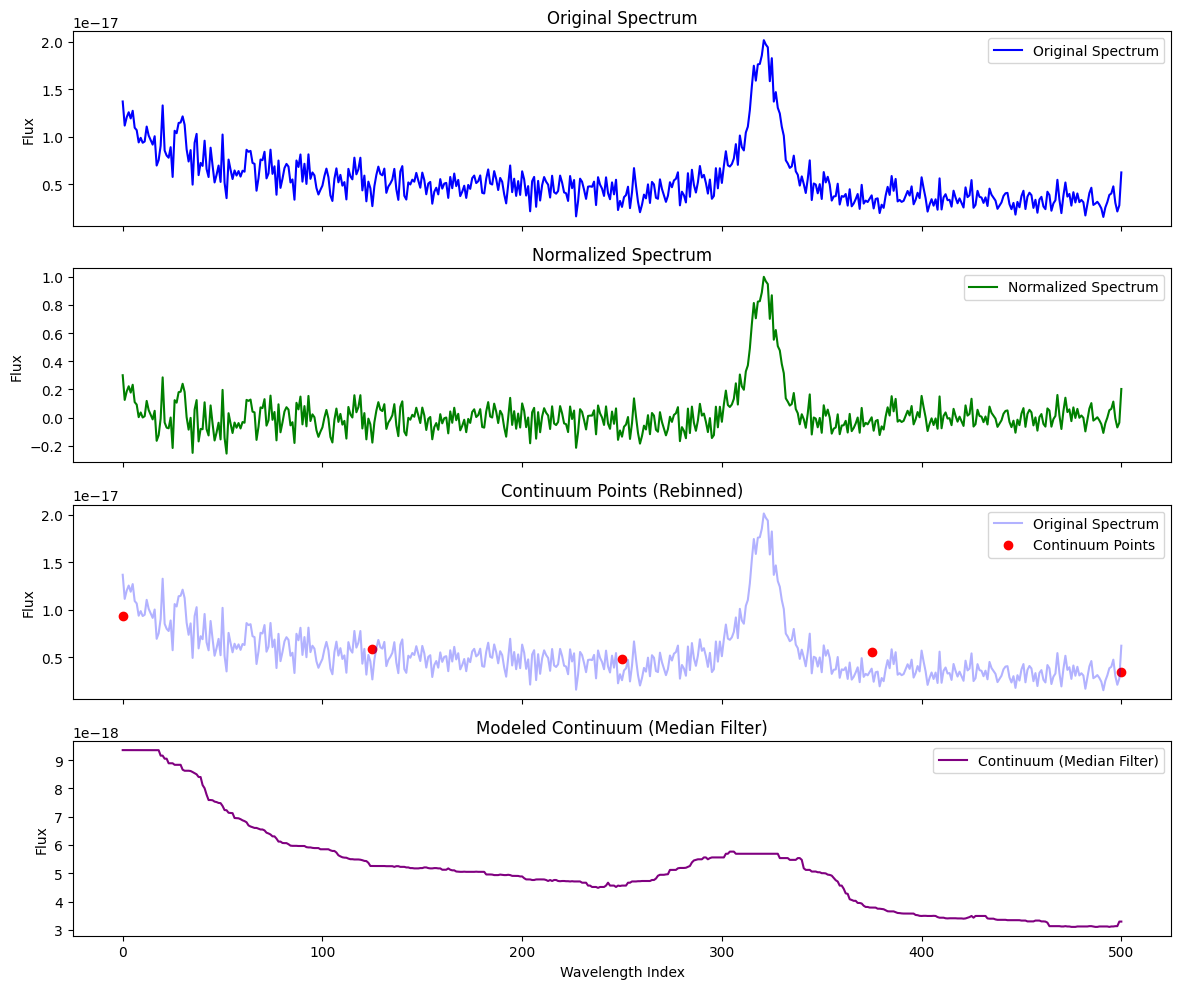

In [114]:
# visualization of the normalization process for a random spectrum, to check if it makes sense

# Select a random index from the training set
random_index = random.randint(0, all_spectra_train.shape[0] - 1)

# Original spectrum
original_spectrum = all_spectra_train[random_index, :]

# Normalized spectrum
normalized_spectrum = all_spectra_train_normalized[random_index, :]

# Continuum model
continuum_model = continuum_train[random_index, :]

# Continuum points for the selected spectrum
continuum_points = continuum_points_train[random_index, :]

# ----------------------------- Visualisation -----------------------------

# Plotting the original spectrum, normalized spectrum, and continuum points
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Original spectrum
axes[0].plot(original_spectrum, color='blue', label='Original Spectrum')
axes[0].set_ylabel("Flux")
axes[0].set_title("Original Spectrum")
axes[0].legend()

# Normalized spectrum
axes[1].plot(normalized_spectrum, color='green', label='Normalized Spectrum')
axes[1].set_ylabel("Flux")
axes[1].set_title("Normalized Spectrum")
axes[1].legend()

# Continuum Points
wavelength_indices = np.linspace(0, len(original_spectrum) - 1, num=num_bins)  # To match with continuum points
axes[2].plot(original_spectrum, color='blue', alpha=0.3, label='Original Spectrum')  # Add original for reference
axes[2].scatter(wavelength_indices, continuum_points, color='red', label='Continuum Points')
axes[2].set_ylabel("Flux")
axes[2].set_title("Continuum Points (Rebinned)")
axes[2].legend()

# Continuum (continuum_train)
axes[3].plot(continuum_train[random_index, :], color='purple', label='Continuum (Median Filter)')
axes[3].set_ylabel("Flux")
axes[3].set_xlabel("Wavelength Index")
axes[3].set_title("Modeled Continuum (Median Filter)")
axes[3].legend()

plt.tight_layout()
plt.show()


#### validation set

In [117]:
df_val = pd.read_pickle('validation_dataset.pickle')

# Extract features for validation set
all_spectra_val = np.stack(df_val['spectrum'].values)
all_spectra_val.shape

# Normalization of validation spectra
all_spectra_val_normalized = np.zeros(all_spectra_val.shape)

# Continuum array
continuum_val = np.zeros(all_spectra_val.shape)

# definition of continuum points
num_bins = 5
continuum_points_val = np.zeros((all_spectra_val.shape[0], num_bins)) # Corrected shape

continuum_median = [] # a variable that is only used to store the continuum points in the loop
for i in tqdm(range(all_spectra_val.shape[0]), desc="Processing"):
    # modeling the continuum with a median filter
    continuum_median = scipy.ndimage.median_filter(all_spectra_val[i, :], size=100)
    # storing the continuum (just for checking later on)
    continuum_val[i, :] =  continuum_median
    # subtracting the continuum
    all_spectra_val_normalized[i, :] = all_spectra_val[i, :] - continuum_median
    # normalizing the spectra according to the maximum value
    all_spectra_val_normalized[i, :] = all_spectra_val_normalized[i, :] / all_spectra_val_normalized[i, :].max()
    # rebinning the continuum points
    continuum_points_val[i, :] = rebin_array_with_interpolation(continuum_median, num_bins=num_bins)

# Saving the normalized spectra and continuum points
with open('spectra_val_normalized.pkl', 'wb') as file:
    pickle.dump(all_spectra_val_normalized, file)

# Saving the continuum points
with open('val_continuum.pkl', 'wb') as file:
    pickle.dump(continuum_points_val, file)  


Processing: 100%|██████████| 290/290 [00:00<00:00, 1407.56it/s]


#### test set

In [118]:
df_test = pd.read_pickle('test_dataset.pickle')

# Extract features for test set
all_spectra_test = np.stack(df_test['spectrum'].values)
all_spectra_test.shape

# Normalization of test spectra
all_spectra_test_normalized = np.zeros(all_spectra_test.shape)

# Continuum array
continuum_test = np.zeros(all_spectra_test.shape)

# definition of continuum points
num_bins = 5
continuum_points_test = np.zeros((all_spectra_test.shape[0], num_bins)) # Corrected shape

continuum_median = [] # a variable that is only used to store the continuum points in the loop
for i in tqdm(range(all_spectra_test.shape[0]), desc="Processing"):
    # modeling the continuum with a median filter
    continuum_median = scipy.ndimage.median_filter(all_spectra_test[i, :], size=100)
    # storing the continuum (just for checking later on)
    continuum_test[i, :] =  continuum_median
    # subtracting the continuum
    all_spectra_test_normalized[i, :] = all_spectra_test[i, :] - continuum_median
    # normalizing the spectra according to the maximum value
    all_spectra_test_normalized[i, :] = all_spectra_test_normalized[i, :] / all_spectra_test_normalized[i, :].max()
    # rebinning the continuum points
    continuum_points_test[i, :] = rebin_array_with_interpolation(continuum_median, num_bins=num_bins)

# Saving the normalized spectra and continuum points
with open('spectra_test_normalized.pkl', 'wb') as file:
    pickle.dump(all_spectra_test_normalized, file)

# Saving the continuum points
with open('test_continuum.pkl', 'wb') as file:
    pickle.dump(continuum_points_test, file)  

Processing: 100%|██████████| 291/291 [00:00<00:00, 1422.68it/s]
